In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np

import sys  
sys.path.insert(1, 'funcs')
import ScalarField
import TangentPoint
import TangentPointSet
from featurewind import build_grids

# new cell in main.ipynb
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgba
from scipy.interpolate import griddata, RegularGridInterpolator
from scipy.spatial import cKDTree
from scipy.ndimage import maximum_filter, gaussian_filter

In [18]:
import numpy as np

def generate_random_data(n_points=100, n_features=3, bounding_box=(0, 10, 0, 10)):
    xmin, xmax, ymin, ymax = bounding_box
    # Generate random points within bounding_box
    positions = np.column_stack((
        np.random.uniform(xmin, xmax, n_points),
        np.random.uniform(ymin, ymax, n_points)
    ))
    # Create random feature vectors for each point (each feature vector is 2D)
    all_grad_vectors = np.random.randn(n_points, n_features, 2)
    # Generate feature labels
    feature_labels = [f"Feature {i}" for i in range(n_features)]
    
    return positions, all_grad_vectors, feature_labels

In [19]:
# new cell in main.ipynb
import matplotlib.pyplot as plt
import numpy as np

# Generate random data (if not already generated)
positions, all_grad_vectors, feature_labels = generate_random_data(
    n_points=50, n_features=3, bounding_box=(0, 10, 0, 10)
)

# Define colors for each feature. Extend this list if necessary.
colors = [
    "#4E79A7", "#F28E2B", "#E15759", "#76B7B2",
    "#59A14F", "#EDC949", "#AF7AA1", "#FF9DA7",
    "#9C755F", "#BAB0AC"
]

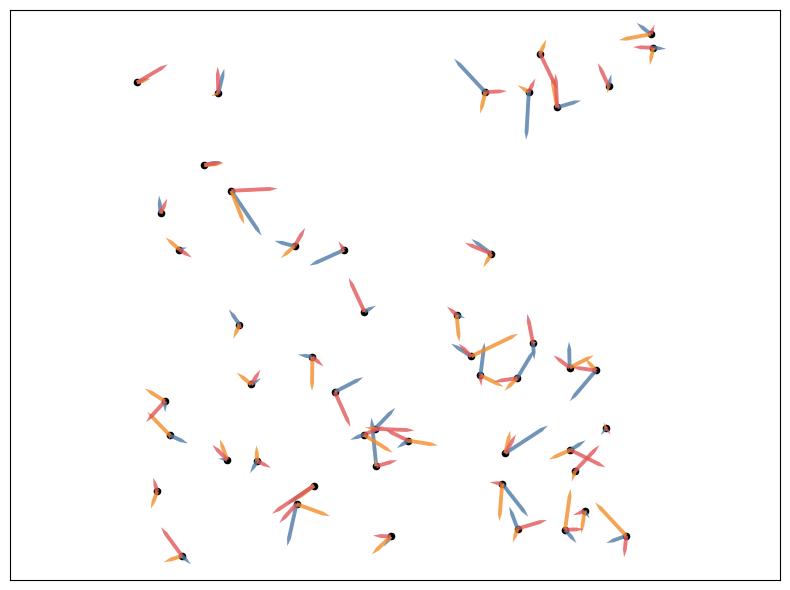

In [20]:
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(positions[:, 0], positions[:, 1], c='black', s=20, label='Points', zorder= 0)

# Plot vector field for each feature using a distinct color
for i, feature in enumerate(feature_labels):
    vectors = all_grad_vectors[:, i, :]  # shape: (n_points, 2)
    plt.quiver(
        positions[:, 0], positions[:, 1],
        vectors[:, 0], vectors[:, 1],
        angles='xy', scale_units='xy', scale=3,
        color=colors[i % len(colors)], alpha=0.8,
        label=feature, 
        width=0.005,     # Reduced quiver shaft width
        headwidth=1,     # Smaller head width
        headlength=2     # Smaller head length
    )

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

# plt.title("Feature Vectors for All Features")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
plt.grid(False)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [21]:
xmin, xmax = positions[:,0].min(), positions[:,0].max()
ymin, ymax = positions[:,1].min(), positions[:,1].max()
bounding_box = [xmin, xmax, ymin, ymax]

In [22]:
def build_grids(positions, grid_res, top_k_indices, all_grad_vectors, kdtree_scale=0.1):
    # (1) Setup interpolation grid and distance mask
    xmin, xmax, ymin, ymax = bounding_box
    grid_x, grid_y = np.mgrid[xmin:xmax:complex(grid_res),
                                ymin:ymax:complex(grid_res)]
    
    # Build a KD-tree and determine distance to the nearest data point at each grid cell
    kdtree = cKDTree(positions)
    grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    distances, _ = kdtree.query(grid_points, k=1)
    dist_grid = distances.reshape(grid_x.shape)
    threshold = max(abs(xmax - xmin), abs(ymax - ymin)) * kdtree_scale
    print("Distance threshold:", threshold)
    
    # (2) Interpolate velocity fields for the top-k features
    grid_u_feats, grid_v_feats = [], []
    for feat_idx in top_k_indices:
        # Extract the vectors for the given feature.
        vectors = all_grad_vectors[:, feat_idx, :]  # shape: (#points, 2)
        # Interpolate each component onto the grid.
        grid_u = griddata(positions, vectors[:, 0], (grid_x, grid_y), method='nearest')
        grid_v = griddata(positions, vectors[:, 1], (grid_x, grid_y), method='nearest')
        # Mask out grid cells too far from any data.
        mask = dist_grid > threshold
        grid_u[mask] = 0.0
        grid_v[mask] = 0.0
        grid_u_feats.append(grid_u)
        grid_v_feats.append(grid_v)
    grid_u_feats = np.array(grid_u_feats)  # shape: (k, grid_res, grid_res)
    grid_v_feats = np.array(grid_v_feats)  # shape: (k, grid_res, grid_res)
    
    # Create the combined (summed) velocity field for the top-k features.
    grid_u_sum = np.sum(grid_u_feats, axis=0)  # shape: (grid_res, grid_res)
    grid_v_sum = np.sum(grid_v_feats, axis=0)  # shape: (grid_res, grid_res)
    
    # (3) Determine the dominant feature at each grid cell (using Gaussian smoothing)
    # Compute the magnitude of each feature on the grid.
    grid_mag_feats = np.sqrt(grid_u_feats**2 + grid_v_feats**2)  # shape: (k, grid_res, grid_res)
    sigma = 1.0  # standard deviation for smoothing
    grid_mag_feats_gaussian = np.zeros_like(grid_mag_feats)
    for f in range(grid_mag_feats.shape[0]):
        grid_mag_feats_gaussian[f] = gaussian_filter(grid_mag_feats[f], sigma=sigma)

    rel_idx = np.argmax(grid_mag_feats_gaussian, axis=0)
    grid_argmax = np.take(top_k_indices, rel_idx)
    # print("Grid test shape:", np.unique(grid_argmax.flatten()))
    
    # Optionally save the dominant feature grid.
    np.savetxt("grid_argmax.csv", np.argmax(grid_mag_feats, axis=0), delimiter=",", fmt="%d")
    np.savetxt("grid_argmax_local.csv", grid_argmax, delimiter=",", fmt="%d")
    
    # (4) Build grid interpolators from the computed fields.
    interp_u_sum = RegularGridInterpolator((grid_x[:, 0], grid_y[0, :]),
                                             grid_u_sum, bounds_error=False, fill_value=0.0)
    interp_v_sum = RegularGridInterpolator((grid_x[:, 0], grid_y[0, :]),
                                             grid_v_sum, bounds_error=False, fill_value=0.0)
    interp_argmax = RegularGridInterpolator((grid_x[:, 0], grid_y[0, :]),
                                             grid_argmax, method='nearest',
                                             bounds_error=False, fill_value=-1)
    
    return interp_u_sum, interp_v_sum, interp_argmax, grid_x, grid_y, grid_u_sum, grid_v_sum

In [23]:
interp_u_sum, interp_v_sum, interp_argmax, grid_x, grid_y, grid_u_sum, grid_v_sum = build_grids(
    positions, 10, [0,1,2], all_grad_vectors, kdtree_scale=0.1
)

Distance threshold: 0.9912767354097434


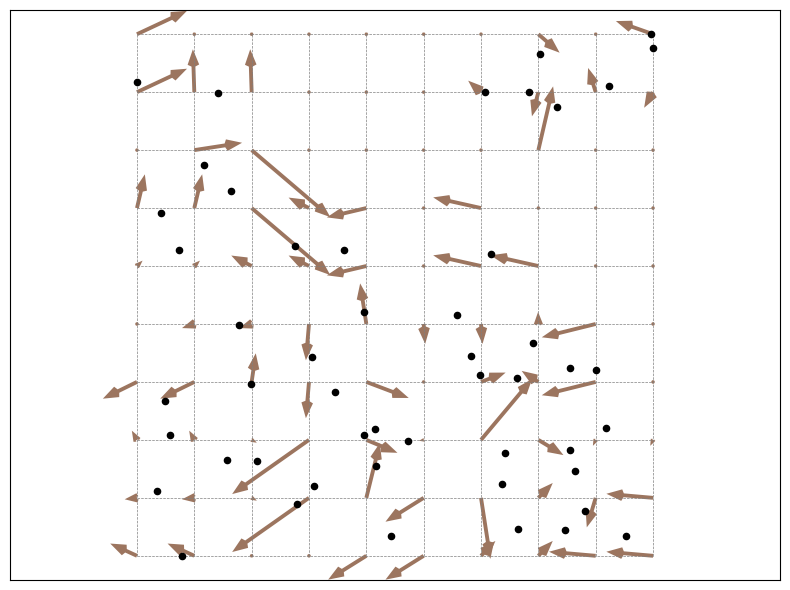

In [24]:
# new cell in main.ipynb
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Draw grid lines using grid_x and grid_y arrays
n_rows, n_cols = grid_x.shape

# Draw vertical grid lines
for col in range(n_cols):
    plt.plot(grid_x[:, col], grid_y[:, col], color='gray', linestyle='--', linewidth=0.5)

# Draw horizontal grid lines
for row in range(n_rows):
    plt.plot(grid_x[row, :], grid_y[row, :], color='gray', linestyle='--', linewidth=0.5)

# Overlay the vector field on the grid using quiver
plt.quiver(
    grid_x, grid_y,
    grid_u_sum, grid_v_sum,
    color='#9C755F', scale=50, width=0.005, headwidth=3, headlength=4
)

# Overlay data points for reference
plt.scatter(positions[:, 0], positions[:, 1], c='black', s=20, label='Data Points', zorder=3)

# plt.title("Grid Visualization with Grid Lines and Summed Velocity Field")
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.tight_layout()
plt.show()